In [1]:
import torch
import numpy as np

from vae import resVAE
from data import make_pinwheel_data
from svae import SVAE

from distributions import NormalInverseWishart, Dirichlet

from distributions import categorical, gaussian

from plot.plot import plot_reconstruction

In [2]:
hyperparameters = {
    "VAE_parameters": {
        "latent_dim": 2,
        "input_size": 2,
        "hidden_size": 40,
        "recon_loss": "likelihood",
        "name": "vae",
    }, "pinwheel_data_parameters": {
        "radial_std": 0.3,
        "tangential_std": 0.05,
        "num_classes": 5,
        "num_per_class": 100,
        "rate": 0.25,
    },
}

In [3]:
# generate synthetic data
data = make_pinwheel_data(**hyperparameters["pinwheel_data_parameters"])

In [4]:
# get recognition network
network = resVAE(**hyperparameters["VAE_parameters"])

# get svae model
model = SVAE(network)
model.load_model()

loaded model from /var/tmp/vandenheu/SVAE/vae.pt


/var/tmp/vandenheu/SVAE/distributions/dirichlet.py:31: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /tmp/xdg_cache_vandenheu/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  stats = torch.digamma(alpha) - torch.digamma(torch.sum(alpha, -1, keepdim=True))


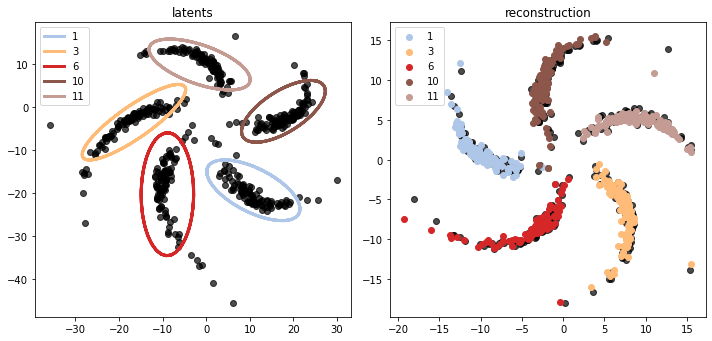

In [5]:
# sanity check if everything is loaded and trained correctly
recon, _, latents, classes = model.forward(torch.tensor(data).to("cuda:0").float())

plot_reconstruction(
    obs=data,
    mu = recon.cpu().detach().numpy(),
    latent=latents.cpu().detach().numpy(),
    eta_theta=model.eta_theta,
    classes=classes.cpu().detach().numpy()
)

/tmp/ipykernel_1073534/2606375157.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  recon, _ = model.decode(torch.tensor(latent_samples, device="cuda:0").float())


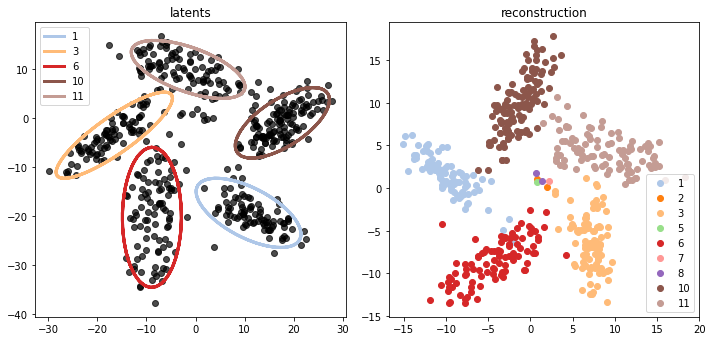

In [6]:
# GENERATE NEW SAMPLES

dir_natparam, niw_natparam = model.eta_theta

# sample weights for the labels from global dirichlet
labels_weights = Dirichlet(dir_natparam).sample(500)

# get class assignments z using the weights
labels_one_hot = categorical.sample(labels_weights)
labels = np.argmax(labels_one_hot, axis=-1)

# for every data-point samples it's gaussian parameters, according to the class it belongs to
gaussian_parameter_samples = NormalInverseWishart(niw_natparam).sample(labels)

mu_samples, Sigma_samples = zip(*gaussian_parameter_samples)
# samples latent data points x
latent_samples = gaussian.sample(np.array(mu_samples), np.array(Sigma_samples))

# decode the newly samples latents x into reconstruction y
recon, _ = model.decode(torch.tensor(latent_samples, device="cuda:0").float())

plot_reconstruction(
    mu=recon.cpu().detach().numpy(),
    latent=latent_samples,
    eta_theta=model.eta_theta,
    classes=labels
)

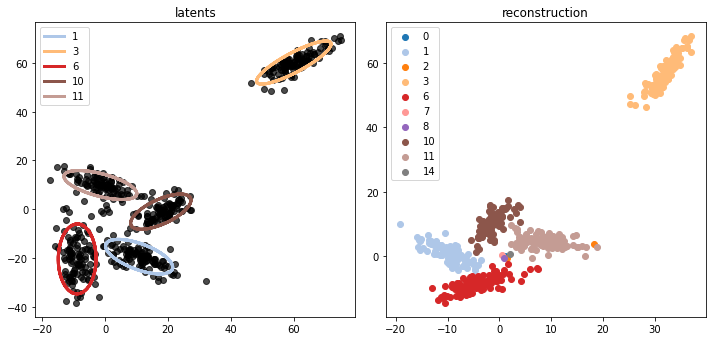

In [7]:
# DO TRANSFORMATION

# unpack the paramaters
dir_natparam, niw_natparam = model.eta_theta
kappa, mu_0, Phi, nu = NormalInverseWishart(niw_natparam).natural_to_standard()

# move one of the clusters
mu_0[3] =+ torch.tensor([60, 60], device="cuda:0")

# pack the parameters
niw_natparam = NormalInverseWishart(niw_natparam).standard_to_natural(kappa, mu_0, Phi, nu)
eta_theta = (dir_natparam, niw_natparam)

# update the svae global parameters with the transformation
model.eta_theta = eta_theta

# GENERATE NEW SAMPLES

# sample weights for the labels from global dirichlet
labels_weights = Dirichlet(dir_natparam).sample(500)

# get class assignments z using the weights
labels_one_hot = categorical.sample(labels_weights)
labels = np.argmax(labels_one_hot, axis=-1)

# for every data-point samples it's gaussian parameters, according to the class it belongs to
gaussian_parameter_samples = NormalInverseWishart(niw_natparam).sample(labels)

mu_samples, Sigma_samples = zip(*gaussian_parameter_samples)
# samples latent data points x
latent_samples = gaussian.sample(np.array(mu_samples), np.array(Sigma_samples))

# decode the newly samples latents x into reconstruction y
recon, _ = model.decode(torch.tensor(latent_samples, device="cuda:0").float())

plot_reconstruction(
    mu=recon.cpu().detach().numpy(),
    latent=latent_samples,
    eta_theta=model.eta_theta,
    classes=labels
)